### **4.Model Testing**

After constructing our basic model and estimated model parameters, we adapt p-value tests to evaluate our model performance on another set of collected data. This part fouses on how much are data generated by our estimated model are correlated with our validation set.

#### **4.1 Validation Data Preprocessing** 
Based on our previously constructed PDF:
$$f(out_i; \alpha, \beta, c) = \frac{out_i^{\alpha-1} \cdot (U_i - out_i)^{\beta-1}}{U_i^{\alpha+\beta-1} \cdot B(\alpha, \beta)}$$
The PDF of normalized $\frac{out_i}{U_i}$ is a standard $\mathrm{Beta}(\alpha, \beta)$ distribution on $[0, 1]$. For uniformity and convenience to generate synthetic data, we do the following transformation to our validation data:

In [87]:
import numpy as np
import pandas as pd
from scipy.stats import beta, ks_2samp, chi2, chi2_contingency
import matplotlib.pyplot as plt

# MLE Parameters
alpha = 1.00
beta_param = 1.00  # Renamed to avoid conflict
c = 2.00

# ---Expected data preprocess---
file_path = "../Data/15/Dataset-Validate.CSV"
val_data = pd.read_csv(file_path)  # Columns: 'rem', 'in', 'out'
val_data['U'] = (val_data['in'] * c) / val_data['rem']
val_data['y'] = val_data['out'] / val_data['U']

# Due to WeChat's round down on the money, the lower bound after normalize leaks below 0.05.
# Fix that by adding a hard filter.
y_real = val_data['y'].values
tolerance = 2e-3
for i in range(len(y_real)):
        if y_real[i] < 0.05:
            assert 0.05 - y_real[i] < tolerance 
            y_real[i] = 0.05
n_real = len(y_real)

From the previously guaranteed minimum mechanism, the minimum money one can receive in a single grab is $\frac{in_i}{10 * rem_i}$ rounded down, which is approximately $5\%$ of the highest money one can grab given the same condition. To prevent downward leakage, we add a hard filter to maintain consistency of the data. The tolerance ensures no out-of-expected data is ignored during filtering process, and the dataset still reflects the mechanism of WeChat Red Packet mechanism accurately.

#### **4.2 Synthetic Data Generating**
Two Sample P-value tests requires two sets of data to conclude whether they are likely to come from the same distribution or not. By using the MLE parameters and standard $\mathrm{Beta}$ PDF, the synthetic data is expected to have simmilar behave with the validation data.

In [88]:
# ---Model Data Gen---
def generate_synthetic_data(n_samples=None, seed=42):
    if n_samples is None:
        n_samples = n_real    
    np.random.seed(seed)
    y_synth = beta.rvs(alpha, beta_param, size=n_samples)

    # By the observed lower bound pattern, add a filter accordingly.
    for i in range(len(y_synth)):
        if y_synth[i] < 0.05:
            y_synth[i] = 0.05

    return y_synth

y_synth = generate_synthetic_data(n_samples=n_real, seed=632)

According to the lower bound mechanism, filtering the smallest part of data should receive a better result (see Part **4.5**).

#### **4.3 Two-Sample Kolmogorov-Smirnov Test**
Two-Sample KS Test considers the overall simmilarity of the two datasets' underlying distributions by calculating the maximum vertical distance between two ECDFs, which is globally determined but locally sensitive.  

Here we set the double-sided null hypothesis $H_0$: The validation data and synthetic data are consistent with coming from the same distribution.

##### **4.3.1 Single Round Example**

TWO-SAMPLE KOLMOGOROV-SMIRNOV TEST RESULTS
Sample sizes: Validation data = 1170, Synthetic data = 1170
KS Statistic: 0.015385
P-value: 0.999101

Result: Fail to reject the null hypothesis at 5% significance level.
The validation data and synthetic data are consistent with coming from the SAME distribution.


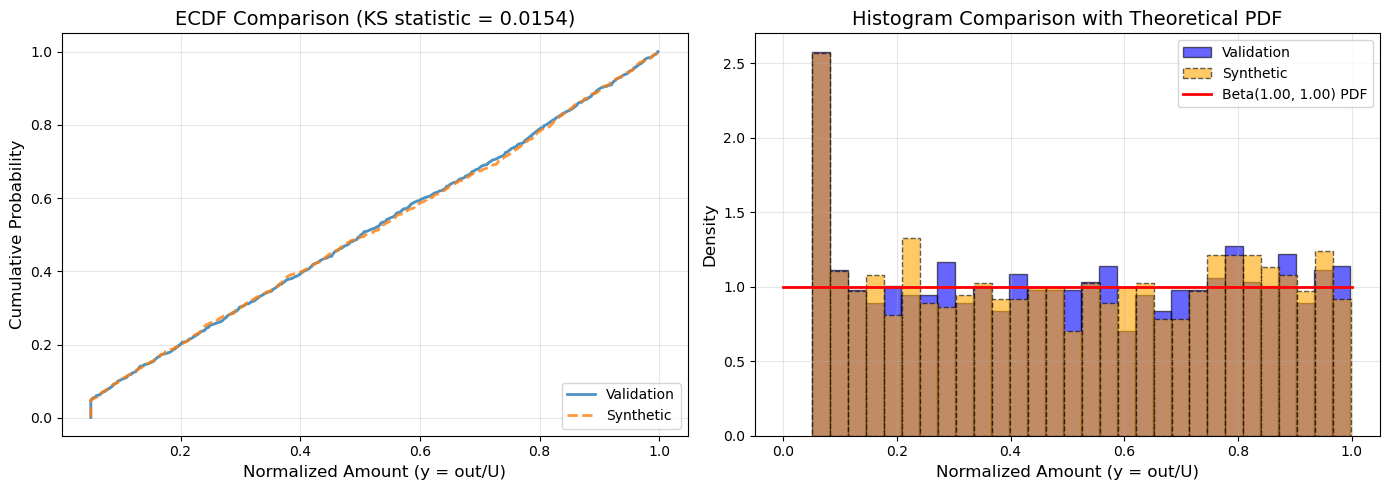

DESCRIPTIVE STATISTICS
Statistic            Val Data        Synthetic Data 
--------------------------------------------------
Mean                 0.5072          0.5085         
Std Dev              0.2904          0.2922         
Min                  0.0500          0.0500         
Median               0.5020          0.5096         
Max                  0.9976          0.9997         


In [100]:
# ---KS Test two sample---
def do_KS_test(y_real, y_synth):
    ks_statistic, p_value = ks_2samp(y_real, y_synth)
    print("=" * 50)
    print("TWO-SAMPLE KOLMOGOROV-SMIRNOV TEST RESULTS")
    print("=" * 50)
    print(f"Sample sizes: Validation data = {n_real}, Synthetic data = {len(y_synth)}")
    print(f"KS Statistic: {ks_statistic:.6f}")
    print(f"P-value: {p_value:.6f}")
    print()

    if p_value < 0.05:
        print("Result: Reject the null hypothesis at 5% significance level.")
        print("The validation data and synthetic data appear to come from DIFFERENT distributions.")
    else:
        print("Result: Fail to reject the null hypothesis at 5% significance level.")
        print("The validation data and synthetic data are consistent with coming from the SAME distribution.")
    
    return (ks_statistic, p_value)

ks_statistic, p_value = do_KS_test(y_real, y_synth)

# ---Visualize---
def plot_ecdf_comparison(y_real, y_synth, bins=50):    
    def ecdf(data):
        x = np.sort(data)
        y = np.arange(1, len(x) + 1) / len(x)
        return x, y
    
    x_real, y_ecdf_real = ecdf(y_real)
    x_synth, y_ecdf_synth = ecdf(y_synth)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # ECDF
    axes[0].plot(x_real, y_ecdf_real, label='Validation', linewidth=2, alpha=0.8)
    axes[0].plot(x_synth, y_ecdf_synth, label='Synthetic', linewidth=2, alpha=0.8, linestyle='--')
    axes[0].set_xlabel('Normalized Amount (y = out/U)', fontsize=12)
    axes[0].set_ylabel('Cumulative Probability', fontsize=12)
    axes[0].set_title(f'ECDF Comparison (KS statistic = {ks_statistic:.4f})', fontsize=14)
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    
    # Histogram comparison
    axes[1].hist(y_real, bins=bins, density=True, alpha=0.6, 
                 label='Validation', color='blue', edgecolor='black')
    axes[1].hist(y_synth, bins=bins, density=True, alpha=0.6, 
                 label='Synthetic', color='orange', edgecolor='black', linestyle='--')
    
    # Theoretical Beta PDF (Uniform)
    x_pdf = np.linspace(0, 1, 1000)
    y_pdf = beta.pdf(x_pdf, alpha, beta_param)
    axes[1].plot(x_pdf, y_pdf, 'r-', linewidth=2, label=f'Beta({alpha:.2f}, {beta_param:.2f}) PDF')
    
    axes[1].set_xlabel('Normalized Amount (y = out/U)', fontsize=12)
    axes[1].set_ylabel('Density', fontsize=12)
    axes[1].set_title('Histogram Comparison with Theoretical PDF', fontsize=14)
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    print("=" * 50)
    print("DESCRIPTIVE STATISTICS")
    print("=" * 50)
    print(f"{'Statistic':<20} {'Val Data':<15} {'Synthetic Data':<15}")
    print("-" * 50)
    print(f"{'Mean':<20} {np.mean(y_real):<15.4f} {np.mean(y_synth):<15.4f}")
    print(f"{'Std Dev':<20} {np.std(y_real):<15.4f} {np.std(y_synth):<15.4f}")
    print(f"{'Min':<20} {np.min(y_real):<15.4f} {np.min(y_synth):<15.4f}")
    print(f"{'Median':<20} {np.median(y_real):<15.4f} {np.median(y_synth):<15.4f}")
    print(f"{'Max':<20} {np.max(y_real):<15.4f} {np.max(y_synth):<15.4f}")

plot_ecdf_comparison(y_real, y_synth, bins=30)

The `P-value` is significantly high with main influencing factors `KS statistic = 0.015` and `Sample size = 1170`. We don't have enough evidence to reject null hypothesis under significance value $0.05$. Our model performs well under current simulation.  

Visualize the results. Intuitively we could conclude that the two ECDFs fits well, the lower bound mechanism can be clearly seen on both plots.  

From the perspective of statistical data, our synthetic data and validation (real) data also behaves simmilarly, supporting the good performance of model.

#### **4.3.2 Multiple Round Robustness Test**


ROBUSTNESS ANALYSIS (500 simulations)
KS Statistic - Mean: 0.0316, Std: 0.0092
P-value - Mean: 0.6122, Std: 0.2809
Proportion of tests rejecting H0 (p < 0.05): 0.60%


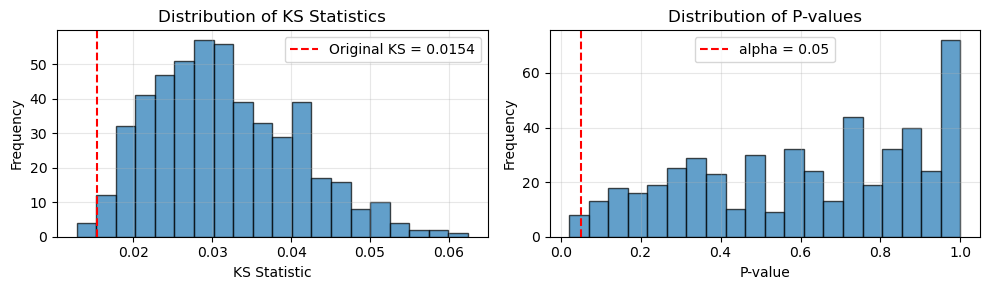

In [98]:
# ---Multiple rounds for reliability---
def multiple_ks_simulations(y_real, n_simulations, seed_start):
    ks_stats = []
    p_values = []
    
    for i in range(n_simulations):
        y_synth_i = generate_synthetic_data(n_samples=len(y_real), 
                                           seed=seed_start + i)
        ks_stat_i, p_value_i = ks_2samp(y_real, y_synth_i)
        ks_stats.append(ks_stat_i)
        p_values.append(p_value_i)
    
    ks_stats = np.array(ks_stats)
    p_values = np.array(p_values)
    
    print("=" * 50)
    print(f"ROBUSTNESS ANALYSIS ({n_simulations} simulations)")
    print("=" * 50)
    print(f"KS Statistic - Mean: {np.mean(ks_stats):.4f}, Std: {np.std(ks_stats):.4f}")
    print(f"P-value - Mean: {np.mean(p_values):.4f}, Std: {np.std(p_values):.4f}")
    print(f"Proportion of tests rejecting H0 (p < 0.05): "
          f"{np.mean(np.array(p_values) < 0.05):.2%}")
    
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.hist(ks_stats, bins=20, edgecolor='black', alpha=0.7)
    plt.axvline(ks_statistic, color='red', linestyle='--', 
                label=f'Original KS = {ks_statistic:.4f}')
    plt.xlabel('KS Statistic')
    plt.ylabel('Frequency')
    plt.title('Distribution of KS Statistics')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.hist(p_values, bins=20, edgecolor='black', alpha=0.7)
    plt.axvline(0.05, color='red', linestyle='--', label='alpha = 0.05')
    plt.xlabel('P-value')
    plt.ylabel('Frequency')
    plt.title('Distribution of P-values')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

multiple_ks_simulations(y_real, n_simulations=500, seed_start=632)

Multiple rounds of tests should be carried out to prevent accidental misevaluation of the model.  

From the plot we could see our single round example is indeed over optimistic since its KS statistic is in the smallest $\frac{1}{10}$ among all 500 simulations. But overall P-values are concentrated below 1, and the reject rate of null hypothethis is $0.60\%$.  

These results agree with our first conclusion and ensure its reliability.

#### **4.4 Chi-Square Homogenity Test**
The Chi-Square Homogenity Test assesses whether multiple (two in a single round in our problem) independent groups have the same distribution on a single categorical variable. By comparing the observed frequency and expected frequency under fixed sum of group and category margins, it calculates the degree of deviation to obtain conclusion.  

Here the $H_0$ is: The validation data and synthetic data have the same distribution on the category decided by constructed optimal bins.

##### **4.4.1 Chi-Square Structure Construction**

In [91]:
# ---Chi prepare---
def determine_optimal_bins(data, min_expected=5, max_bins=20):
    """Determine optimal bins ensuring expected frequency >= min_expected."""
    n = len(data)
    k_sturges = int(np.ceil(np.log2(n)) + 1)
    n_bins = min(max_bins, max(3, k_sturges))
    
    # Try to find bins with sufficient expected frequency
    for k in range(n_bins, 2, -1):
        bin_edges = np.linspace(0, 1, k + 1)
        
        cdf_values = beta.cdf(bin_edges, alpha, beta_param)
        expected_probs = np.diff(cdf_values)
        expected = expected_probs * n
        
        if np.all(expected >= min_expected):
            return bin_edges, k
    
    # If no binning satisfies, use minimum 3 bins
    return np.linspace(0, 1, 4), 3

def create_contingency_table(y1, y2, bin_edges):
    """Create 2*K contingency table for two samples."""
    hist1, _ = np.histogram(y1, bins=bin_edges)
    hist2, _ = np.histogram(y2, bins=bin_edges)
    
    contingency_table = np.vstack([hist1, hist2])
    
    return contingency_table

We divide the interval $[0, 1]$ into `n_bins` equally, and estimates $n$ with Freedman–Diaconis rule, while ensuring in every interval, our validation data has at least $5$ values. We bound $n$ with minimum $3$ and maximum $20$ bins.

After defining the categorial variable, we construct the contigency table with row representing the groups and column representing categories.

##### **4.4.2 Single Round Example**

In [92]:
# ---Chi Squre Goodness-of-fit---
def chi_square_gof_test(y_data, bin_edges):
    """Perform chi-square gof test for one sample against Beta distribution."""
    observed, _ = np.histogram(y_data, bins=bin_edges)
    n_bins = len(bin_edges) - 1
    
    cdf_values = beta.cdf(bin_edges, alpha, beta_param)
    expected_probs = np.diff(cdf_values)
    expected = expected_probs * len(y_data)
    expected = np.maximum(expected, 1e-10)
    chi2_stat = np.sum((observed - expected)**2 / expected)
    df = n_bins - 1
    p_value = 1 - chi2.cdf(chi2_stat, df)
    
    return chi2_stat, p_value, df, observed, expected

# ---Chi Square Homogeneity Test---
def chi_square_homogeneity_test(y1, y2, bin_edges):
    contingency_table = create_contingency_table(y1, y2, bin_edges)
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    return chi2_stat, p_value, dof, contingency_table, expected

# ---Chi Gof and Homo---
def perform_all_chi_tests(y_real, y_synth):
    """Null hypothesis **H0**: "Data likely from same distribution."""
    
    print("=" * 70)
    print("CHI-SQUARE TESTS RESULTS")
    print("=" * 70)
    
    bin_edges, n_bins = determine_optimal_bins(y_real, min_expected=5)
    print(f"\nUsing {n_bins} bins with edges: {bin_edges.round(3)}")
    
    # Test 1
    print("\n1. GOF TEST (Validation vs Theoretical)")
    print("-" * 60)
    chi2_gof_stat, chi2_gof_p, df_gof, obs_gof, exp_gof = chi_square_gof_test(y_real, bin_edges)
    print(f"   Chi-square statistic: {chi2_gof_stat:.4f}")
    print(f"   Degrees of freedom: {df_gof}")
    print(f"   P-value: {chi2_gof_p:.6f}")
    
    if chi2_gof_p < 0.05:
        print("   Result: REJECT null hypothesis - Data doesn't follow Beta distribution")
    else:
        print("   Result: FAIL TO REJECT - Data consistent with Beta distribution")
    
    # Test 2
    print("\n2. GOF TEST (Synthetic vs Theoretical)")
    print("-" * 60)
    chi2_gof_synth_stat, chi2_gof_synth_p, df_gof_synth, obs_gof_synth, exp_gof_synth = chi_square_gof_test(y_synth, bin_edges)
    print(f"   Chi-square statistic: {chi2_gof_synth_stat:.4f}")
    print(f"   Degrees of freedom: {df_gof_synth}")
    print(f"   P-value: {chi2_gof_synth_p:.6f}")
    
    if chi2_gof_synth_p < 0.05:
        print("   Result: REJECT - Synthetic data doesn't follow Beta (unexpected!)")
    else:
        print("   Result: FAIL TO REJECT - Synthetic data matches Beta (as expected)")
    
    # Test 3
    print("\n3. HOMOGENEITY TEST (Validation vs Synthetic)")
    print("-" * 60)
    chi2_homog_stat, chi2_homog_p, df_homog, cont_table, expected_homog = chi_square_homogeneity_test(y_real, y_synth, bin_edges)
    print(f"   Chi-square statistic: {chi2_homog_stat:.4f}")
    print(f"   Degrees of freedom: {df_homog}")
    print(f"   P-value: {chi2_homog_p:.6f}")
    print(f"   Contingency table shape: {cont_table.shape}")
    
    if chi2_homog_p < 0.05:
        print("   Result: REJECT - Samples come from different distributions")
    else:
        print("   Result: FAIL TO REJECT - Samples likely from same distribution")

    return {
        'bin_edges': bin_edges,
        'gof_real': (chi2_gof_stat, chi2_gof_p, df_gof, obs_gof, exp_gof),
        'gof_synth': (chi2_gof_synth_stat, chi2_gof_synth_p, df_gof_synth, obs_gof_synth, exp_gof_synth),
        'homogeneity': (chi2_homog_stat, chi2_homog_p, df_homog, cont_table, expected_homog),
    }

results = perform_all_chi_tests(y_real, y_synth)

CHI-SQUARE TESTS RESULTS

Using 12 bins with edges: [0.    0.083 0.167 0.25  0.333 0.417 0.5   0.583 0.667 0.75  0.833 0.917
 1.   ]

1. GOF TEST (Validation vs Theoretical)
------------------------------------------------------------
   Chi-square statistic: 4.8513
   Degrees of freedom: 11
   P-value: 0.938154
   Result: FAIL TO REJECT - Data consistent with Beta distribution

2. GOF TEST (Synthetic vs Theoretical)
------------------------------------------------------------
   Chi-square statistic: 11.0872
   Degrees of freedom: 11
   P-value: 0.435989
   Result: FAIL TO REJECT - Synthetic data matches Beta (as expected)

3. HOMOGENEITY TEST (Validation vs Synthetic)
------------------------------------------------------------
   Chi-square statistic: 2.0255
   Degrees of freedom: 11
   P-value: 0.998404
   Contingency table shape: (2, 12)
   Result: FAIL TO REJECT - Samples likely from same distribution


We've got 3 set of data with possibly same distribution information: Validation, Theoretical and synthetic. The first two fitness test checks our direct model PDF's consistency with validation data and data generating process correctness respectively.  
The third one is an example round homogenity test of validation data.  

We didn't see the 'lower bound peak' here even our given data depicts this patter, because the modified data still falls in the same bin after filtering. Thus, our theoretical PDF without lower bound also passes the first two fitness test as expected.

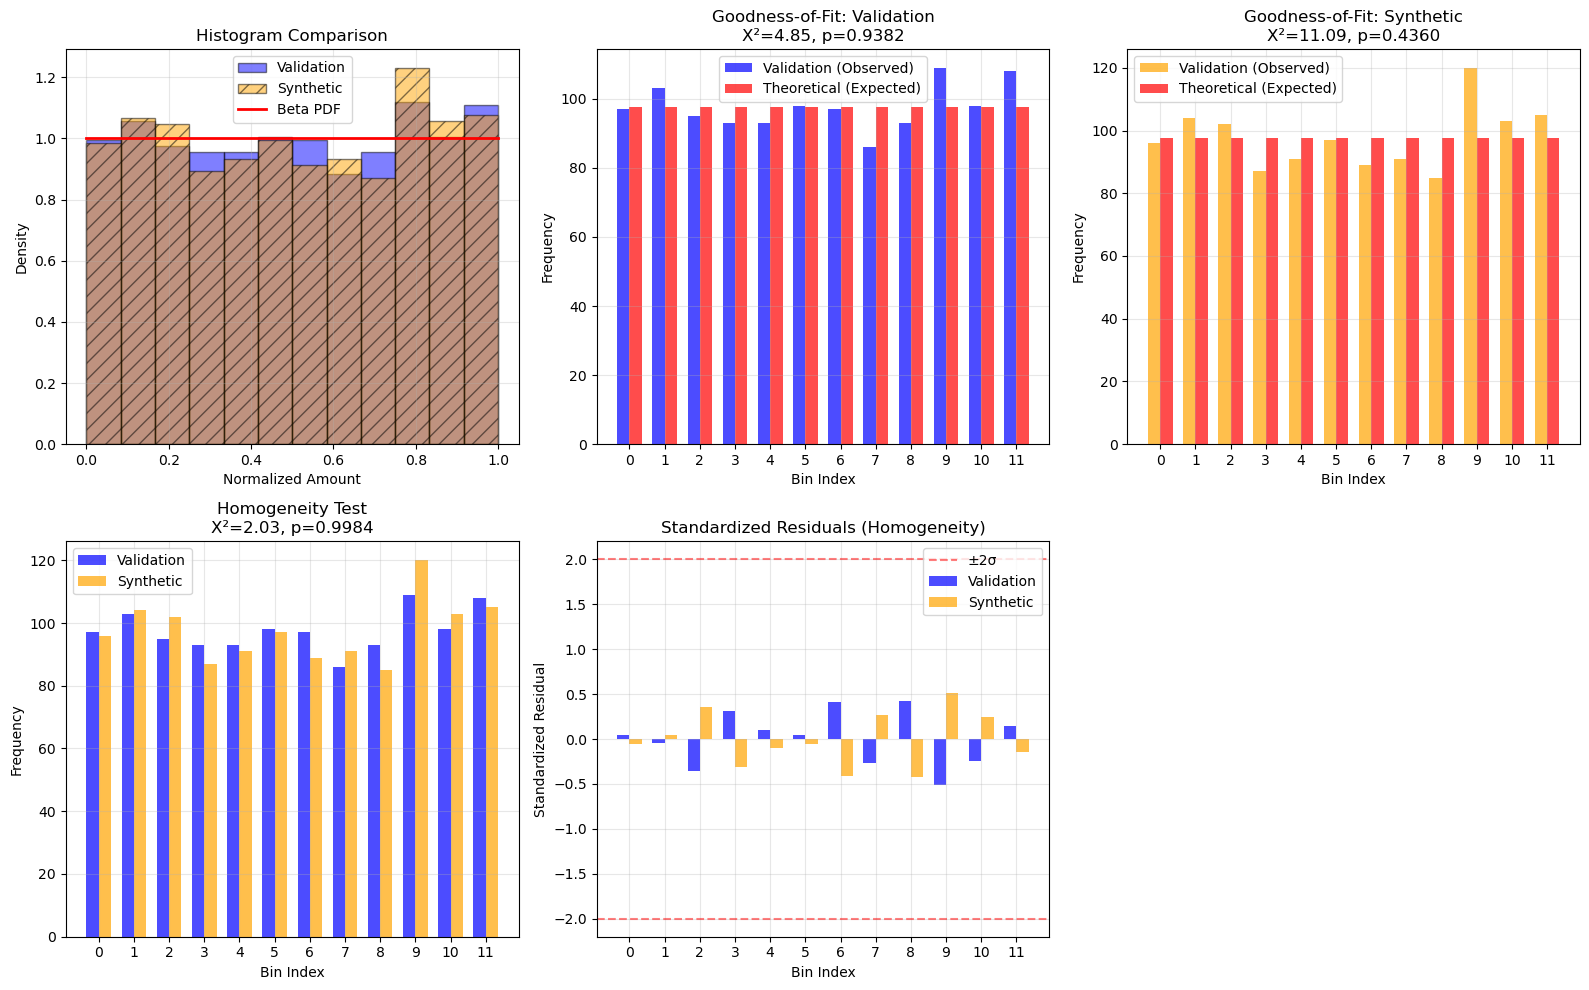

TEST RESULTS
Gof Validation                      p=0.938154 PASS
Gof Synthetic                       p=0.435989 PASS
Homogeneity                         p=0.998404 PASS

INTERPRETATION
Both tests suggest the model fits well:
1. Validation data follows Beta distribution
2. Validation and synthetic data come from same distribution
Conclusion: Model is a good fit for the data.


In [102]:
# ---Visualize---
def visualize_chi_test_results(y_real, y_synth, results):    
    bin_edges = results['bin_edges']
    n_bins = len(bin_edges) - 1

    fig = plt.figure(figsize=(16, 10))
    
    # Histogram comparison
    ax1 = plt.subplot(2, 3, 1)
    x = np.linspace(0, 1, 1000)
    y_pdf = beta.pdf(x, alpha, beta_param)
    
    ax1.hist(y_real, bins=bin_edges, density=True, alpha=0.5, 
             color='blue', label='Validation', edgecolor='black')
    ax1.hist(y_synth, bins=bin_edges, density=True, alpha=0.5,
             color='orange', label='Synthetic', edgecolor='black', hatch='//')
    ax1.plot(x, y_pdf, 'r-', linewidth=2, label='Beta PDF')
    ax1.set_xlabel('Normalized Amount')
    ax1.set_ylabel('Density')
    ax1.set_title('Histogram Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Gof observed vs expected model
    ax2 = plt.subplot(2, 3, 2)
    obs_gof, exp_gof = results['gof_real'][3], results['gof_real'][4]
    x_pos = np.arange(n_bins)
    width = 0.35
    
    ax2.bar(x_pos - width/2, obs_gof, width, label='Validation (Observed)', alpha=0.7, color='blue')
    ax2.bar(x_pos + width/2, exp_gof, width, label='Theoretical (Expected)', alpha=0.7, color='red')
    ax2.set_xlabel('Bin Index')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'Goodness-of-Fit: Validation\nX²={results["gof_real"][0]:.2f}, p={results["gof_real"][1]:.4f}')
    ax2.set_xticks(x_pos)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Gof synthetic vs expected model
    ax3 = plt.subplot(2, 3, 3)
    obs_gof_synth, exp_gof_synth = results['gof_synth'][3], results['gof_synth'][4]
    
    ax3.bar(x_pos - width/2, obs_gof_synth, width, label='Validation (Observed)', alpha=0.7, color='orange')
    ax3.bar(x_pos + width/2, exp_gof_synth, width, label='Theoretical (Expected)', alpha=0.7, color='red')
    ax3.set_xlabel('Bin Index')
    ax3.set_ylabel('Frequency')
    ax3.set_title(f'Goodness-of-Fit: Synthetic\nX²={results["gof_synth"][0]:.2f}, p={results["gof_synth"][1]:.4f}')
    ax3.set_xticks(x_pos)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Contingency table visualization
    ax4 = plt.subplot(2, 3, 4)
    cont_table = results['homogeneity'][3]
    expected_table = results['homogeneity'][4]
    
    x = np.arange(n_bins)
    ax4.bar(x - width/2, cont_table[0], width, label='Validation', alpha=0.7, color='blue')
    ax4.bar(x + width/2, cont_table[1], width, label='Synthetic', alpha=0.7, color='orange')
    ax4.set_xlabel('Bin Index')
    ax4.set_ylabel('Frequency')
    ax4.set_title(f'Homogeneity Test\nX²={results["homogeneity"][0]:.2f}, p={results["homogeneity"][1]:.4f}')
    ax4.set_xticks(x)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Standardized residuals for homogeneity test
    ax5 = plt.subplot(2, 3, 5)
    standardized_residuals = (cont_table - expected_table) / np.sqrt(expected_table)
    
    ax5.bar(x - width/2, standardized_residuals[0], width, label='Validation', alpha=0.7, color='blue')
    ax5.bar(x + width/2, standardized_residuals[1], width, label='Synthetic', alpha=0.7, color='orange')
    ax5.axhline(y=2, color='r', linestyle='--', alpha=0.5, label='±2σ')
    ax5.axhline(y=-2, color='r', linestyle='--', alpha=0.5)
    ax5.set_xlabel('Bin Index')
    ax5.set_ylabel('Standardized Residual')
    ax5.set_title('Standardized Residuals (Homogeneity)')
    ax5.set_xticks(x)
    ax5.legend(loc='upper right')
    ax5.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # Print primary conclusion
    print("=" * 70)
    print("TEST RESULTS")
    print("=" * 70)
    
    tests = [
        ("Gof Validation", results['gof_real'][1]),
        ("Gof Synthetic", results['gof_synth'][1]),
        ("Homogeneity", results['homogeneity'][1]),
    ]
    
    for test_name, p_value in tests:
        status = "PASS" if p_value >= 0.05 else "FAIL"
        color = '\033[92m' if p_value >= 0.05 else '\033[91m'  # Green/Red
        reset = '\033[0m'
        print(f"{test_name:<35} p={p_value:.6f} {color}{status}{reset}")
    
    print("\n" + "=" * 70)
    print("INTERPRETATION")
    print("=" * 70)
    
    gof_real_p = results['gof_real'][1]
    homogeneity_p = results['homogeneity'][1]
    
    if gof_real_p >= 0.05 and homogeneity_p >= 0.05:
        print("Both tests suggest the model fits well:")
        print("1. Validation data follows Beta distribution")
        print("2. Validation and synthetic data come from same distribution")
        print("Conclusion: Model is a good fit for the data.")
    elif gof_real_p < 0.05 and homogeneity_p >= 0.05:
        print("Conflicting results: Gof rejects but Homogenity accepts")
        print("Possible: Both datasets deviate from Beta in similar ways.")
        print("Conclusion: Model captures relative patterns but not exact distribution.")
    elif gof_real_p >= 0.05 and homogeneity_p < 0.05:
        print("Conflicting results: Gof accepts but Homogeneity rejects")
        print("Possible: Synthetic data doesn't perfectly follow Beta due to sampling variability.")
        print("Conclusion: Model is theoretically correct but synthetic data has sampling error.")
    else:
        print("Both tests reject the null hypotheses:")
        print("Conclusion: Model may not be a good fit for the data.")

visualize_chi_test_results(y_real, y_synth, results)

Model and generated data *passed* all tests. Apart form classical visualize of our test result, the standard residuals plot shows which specific bins contribute most to the overall chi-square statistic, enabling us to diagnose the model problem beyond the p-value.

##### **4.4.3 Multiple Round Robustness Test**

ROBUSTNESS CHECK (500 simulations)

Homogeneity test:
  Mean p-value: 0.7096
  Std p-value: 0.2310
  Rejection rate (p < 0.05): 0.00%

KS test:
  Mean p-value: 0.6122
  Std p-value: 0.2809
  Rejection rate (p < 0.05): 0.60%


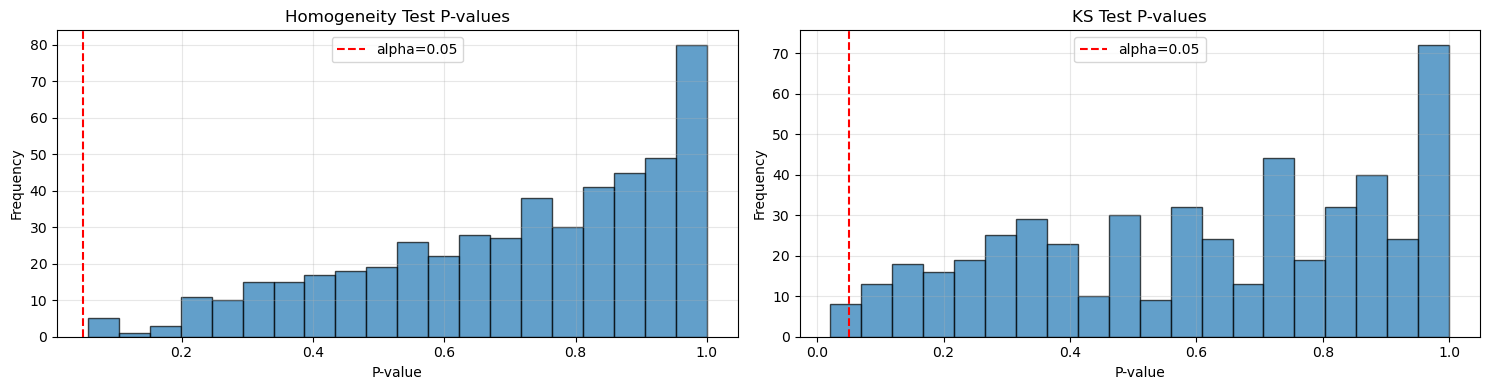

In [94]:
# ---Multiple Rounds ensure reliability---
def multiple_simulation(y_real, n_simulations=100):    
    print("=" * 70)
    print(f"ROBUSTNESS CHECK ({n_simulations} simulations)")
    print("=" * 70)
    
    homogeneity_p_values = []
    ks_p_values = []
    
    bin_edges, _ = determine_optimal_bins(y_real, min_expected=5)
    
    for i in range(n_simulations):
        y_synth_i = generate_synthetic_data(len(y_real), seed=632 + i)

        chi2_homog_stat, chi2_homog_p, _, _, _ = chi_square_homogeneity_test(y_real, y_synth_i, bin_edges)
        homogeneity_p_values.append(chi2_homog_p)
        ks_stat, ks_p = ks_2samp(y_real, y_synth_i)
        ks_p_values.append(ks_p)
    
    print(f"\nHomogeneity test:")
    print(f"  Mean p-value: {np.mean(homogeneity_p_values):.4f}")
    print(f"  Std p-value: {np.std(homogeneity_p_values):.4f}")
    print(f"  Rejection rate (p < 0.05): {np.mean(np.array(homogeneity_p_values) < 0.05):.2%}")
    
    print(f"\nKS test:")
    print(f"  Mean p-value: {np.mean(ks_p_values):.4f}")
    print(f"  Std p-value: {np.std(ks_p_values):.4f}")
    print(f"  Rejection rate (p < 0.05): {np.mean(np.array(ks_p_values) < 0.05):.2%}")
    
    # Plot distribution of p-values
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    
    axes[0].hist(homogeneity_p_values, bins=20, edgecolor='black', alpha=0.7)
    axes[0].axvline(0.05, color='red', linestyle='--', label='alpha=0.05')
    axes[0].set_xlabel('P-value')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Homogeneity Test P-values')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].hist(ks_p_values, bins=20, edgecolor='black', alpha=0.7)
    axes[1].axvline(0.05, color='red', linestyle='--', label='alpha=0.05')
    axes[1].set_xlabel('P-value')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('KS Test P-values')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

multiple_simulation(y_real, n_simulations=500)

Combining Chi-Square Homegenity test and KS test P-value distributions, we admit our model's fitness on WeChat data from different perspectives.

#### **4.5 Lower Bound Verification**
Although we could intuitively find the lower bound mechanism from histograms, we verify it by deleting the filter of our synthetic data to generate standard $\mathrm{Beta}$ distribution and check its fitness by KS test.

ROBUSTNESS ANALYSIS (500 simulations)
KS Statistic - Mean: 0.0506, Std: 0.0061
P-value - Mean: 0.1213, Std: 0.0805
Proportion of tests rejecting H0 (p < 0.05): 19.20%


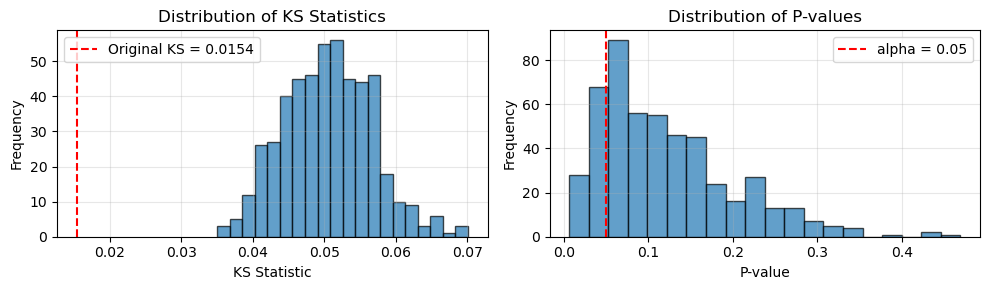

In [104]:
# ---Unfiltered Synthetic data---
def generate_no_thresh_synthetic_data(n_samples=None, seed=42):
    if n_samples is None:
        n_samples = n_real    
    np.random.seed(seed)
    y_synth = beta.rvs(alpha, beta_param, size=n_samples)

    return y_synth

def multiple_no_thresh_ks_simulations(y_real, n_simulations, seed_start):
    ks_stats = []
    p_values = []
    
    for i in range(n_simulations):
        y_synth_i = generate_no_thresh_synthetic_data(n_samples=len(y_real), 
                                           seed=seed_start + i)
        ks_stat_i, p_value_i = ks_2samp(y_real, y_synth_i)
        ks_stats.append(ks_stat_i)
        p_values.append(p_value_i)
    
    ks_stats = np.array(ks_stats)
    p_values = np.array(p_values)
    
    print("=" * 50)
    print(f"ROBUSTNESS ANALYSIS ({n_simulations} simulations)")
    print("=" * 50)
    print(f"KS Statistic - Mean: {np.mean(ks_stats):.4f}, Std: {np.std(ks_stats):.4f}")
    print(f"P-value - Mean: {np.mean(p_values):.4f}, Std: {np.std(p_values):.4f}")
    print(f"Proportion of tests rejecting H0 (p < 0.05): "
          f"{np.mean(np.array(p_values) < 0.05):.2%}")
    
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.hist(ks_stats, bins=20, edgecolor='black', alpha=0.7)
    plt.axvline(ks_statistic, color='red', linestyle='--', 
                label=f'Original KS = {ks_statistic:.4f}')
    plt.xlabel('KS Statistic')
    plt.ylabel('Frequency')
    plt.title('Distribution of KS Statistics')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.hist(p_values, bins=20, edgecolor='black', alpha=0.7)
    plt.axvline(0.05, color='red', linestyle='--', label='alpha = 0.05')
    plt.xlabel('P-value')
    plt.ylabel('Frequency')
    plt.title('Distribution of P-values')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

multiple_no_thresh_ks_simulations(y_real, n_simulations=500, seed_start=632)

![With lower bound](image/KSTestWithLowerBound.png)
Comparing the two images, we could find the KS statistics grows bigger overall without considering the lower bound, and the rejection rate is much higher than before ($19.20\% > 0.60%$).  

Therefore, the *lower bound mechanism* also holds from mathematical perspective.

#### **4.6 Method Comparison and Analysis**
Overall, we adapted two goodness of fit test with p-value, set simmilar null hypothesis, and yields same positive conclusion from different test perspectives. But KS and Chi-Square differ in their focus and execution methods, giving us abundant information, showing unique pros and cons.

##### **4.6.1 Kolmogorov-Smirnov Test**
**Pros:**
1. KS test considers only the ECDF (Empirical Cummulative Probability Density Function), which is a parameter-free method and no hypothesis on shape of data distribution is needed.
2. As said before, KS test is globally determined (take the whole ECDF into consideration) and locally sensitive. The test reflects the margin and shape of the whole distribution.
3. Suitable for both discrete and continuous data. More powerful than Chi-Square on continuous.
4. No binning workload and works on raw data. No information is lost in the process.

**Cons:**
1. The calculation of KS statistics makes it outlier sensitive. Even though two ECDFs appear vsually simmilar in most part, a single outlier significantly affects eventual test result, proposing high requirment on data qualities and careful data preprocessing.
2. When the data has multiple discrete repetitive values, the ECDF may have big step amplitudes, increasing the KS statistic a lot, further leading to data distortion.

##### **4.6.2 Chi-Square Test**
**Pros:**
1. Chi-Square considers the deviation of every category. Their effect won't be shadowed by some single outlier.
2. Plots like standard residual provides diagnose of data beyond p-values, assesing the situation of every bins.
3. Tailoring bins in specific area gives more detailed information.

**Cons:**
1. Different binning affects the accuracy of the test. Good binning methods are required for non-previously categorized.
2. Binning process lose some information of the raw data. For example, the lower bound mechanism isn't reflected in the test.

##### **4.6.3 Analysis**
Overall the KS test provides the information about local consistency, and the Chi Homogenity test evaluates the model performance on the whole distribution interval. The conclusions corroborate each other.  

Since no normal distribution $\mathcal{N}$ is used, we skip the Shapiro-Wilk test.